# Estimate parameters for the nonstationary internal tide model by fitting a Lorentzian to the data


In [1]:
import sfoda.suntans.sunxarray as sxr

import glob
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from cmocean import cm
from s3fs import S3FileSystem, S3Map

/opt/tljh/user/lib/python3.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.11) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [2]:
# %matplotlib notebook

In [3]:
s3login = '/home/jupyter-ubuntu/s3.acacia.login'

with open(s3login) as f:
    lines = f.readlines()

url, key, secret = [ff.strip('\n') for ff in lines[0:3]]
s3 = S3FileSystem(client_kwargs={'endpoint_url':url},
            key=key,
            secret=secret)


In [4]:

# f = S3Map("uwaoceanprocesses-suntans/NWS_2km_GLORYS_2013_2014_ssh_filtered.zarr/", s3=s3)
# NWS_2km_GLORYS_2013_2014_ssh_steric_filtered.zarr/", s3=s3)
# f = S3Map("uwaoceanprocesses-suntans/NWS_2km_GLORYS_2013_2014_ssh_steric_filtered_astrotides.zarr')
f = S3Map("uwaoceanprocesses-suntans/NWS_2km_GLORYS_2013_2014_ssh_steric_filtered_seasonaltides.zarr", s3=s3)
          
ds = xr.open_dataset(f, engine='zarr', chunks={})

# These need filling in??
ds.suntans.xv=ds.xv.values
ds.suntans.yv=ds.yv.values

ds

Changing the _FillValue from -999999 to 999999


<xarray.Dataset>
Dimensions:                      (Nc: 225368, numsides: 8, time: 8761, Np: 454016)
Coordinates:
  * time                         (time) datetime64[ns] 2013-07-01T00:01:00 .....
Dimensions without coordinates: Nc, numsides, Np
Data variables:
    cells                        (Nc, numsides) int32 dask.array<chunksize=(2000, 8), meta=np.ndarray>
    dv                           (Nc) float64 dask.array<chunksize=(2000,), meta=np.ndarray>
    eta_steric_non_phase_locked  (time, Nc) float64 dask.array<chunksize=(8761, 1000), meta=np.ndarray>
    eta_steric_phase_locked      (time, Nc) float64 dask.array<chunksize=(8761, 1000), meta=np.ndarray>
    nfaces                       (Nc) int32 dask.array<chunksize=(2000,), meta=np.ndarray>
    xp                           (Np) float64 dask.array<chunksize=(454016,), meta=np.ndarray>
    xv                           (Nc) float64 dask.array<chunksize=(2000,), meta=np.ndarray>
    yp                           (Np) float64 dask.array<chunksize=(454016,), meta=np.ndarray>
    yv                           (Nc) float64 dask.array<chunksize=(2000,), meta=np.ndarray>
Attributes:
    Author:       mrayson
    Description:  SUNTANS post-processed pressure fields

In [5]:
ds.xv[0:10].values

array([109.00229515, 109.05668874, 109.11208445, 109.16851257,
       109.22591294, 109.28416611, 109.34336307, 109.40331704,
       109.46425027, 109.52604036])

In [6]:
def extract_point(xpt, ypt):
    dist = np.abs( (ds.xv.values-xpt) + 1j*(ds.yv.values-ypt))
    idx = np.argwhere(dist==dist.min())[0,0]

    return ds.isel(Nc=idx).drop_vars(['xp','yp','cells'])


In [7]:
# oh, yeah
import speccy

In [8]:
from gptide import cov
from gptide import GPtideScipy, GPtideToeplitz

In [9]:
from sfoda.utils.harmonic_analysis import getTideFreq

f_cps, _ = getTideFreq(['M2','S2','K1','O1'])
f_cpd = [2*np.pi/ff/86400. for ff in f_cps]
f_cpd

[0.517525050851839, 0.5, 0.9972695689985752, 1.0758059026974014]

In [10]:
import nonstat_itides as nsit

In [32]:
from scipy.special import kv as K_nu
from scipy.special import gamma

def logit(p, scale=1.):
    cff = 1/scale
    return np.log(p*cff/(1-p*cff))

def invlogit(x, scale=1., upper=None, lower=None):
    return scale*np.exp(x)/(1+np.exp(x))

def calc_dist(x, xpr, eps=1e-14):
    dx2 = np.power(x-xpr, 2.)
    dx2[dx2<eps] = eps
    return np.sqrt(dx2)

def gamma_exp(x, xpr, gam, l):
    """γ-exponential covariance function"""
    dx = calc_dist(x, xpr)
    return np.exp(-np.power(dx/l, gam))
    
def matern_general(x, xpr, nu, l):
    """General Matern base function"""
    dx = calc_dist(x, xpr)
    
    cff1 = np.sqrt(2*nu)*dx/l
    #K = np.power(eta, 2.) * np.power(2., 1-nu) / gamma(nu)
    K = np.power(2., 1-nu) / gamma(nu)
    K *= np.power(cff1, nu)
    K *= K_nu(nu,cff1)
    
    #K[np.isnan(K)] = np.power(eta, 2.)
    
    return K

def oscillate_1d_matern(x, xpr, params):
    """
    1D Oscillatory kernel
    """
    eta, d, l, nu = params

    return eta**2 * matern_general(x, xpr, nu, d) * cov.cosine(x, xpr, l)

def oscillate_1d_gammaexp(x, xpr, params):
    """
    1D Oscillatory kernel
    """
    eta, d, l, gam = params

    return eta**2 * gamma_exp(x, xpr, gam, d) * cov.cosine(x, xpr, l)


def oscillate_D2D1_logeta_constant(x, xpr, params, 
                     lt =[ (0.5+0.517525050851839)/2, (0.9972695689985752+1.0758059026974014)/2],
                       itfunc=cov.expquad):

    log_eta1, log_d1, log_eta2, log_d2, log_constant = params
    
    eta1 = np.exp(log_eta1)
    eta2 = np.exp(log_eta2)
    d1 = np.exp(log_d1)
    d2 = np.exp(log_d2)
    constant = np.exp(log_constant)

    C = nsit.oscillate_1d(x, xpr, (eta1, d1, lt[0]), itfunc=itfunc)
    C += nsit.oscillate_1d(x, xpr, (eta2, d2, lt[1]), itfunc=itfunc)
    C[0] = C[0] + constant

    return C

def oscillate_D2D1_gmatern(x, xpr, params, 
                     lt =[ (0.5+0.517525050851839)/2, (0.9972695689985752+1.0758059026974014)/2]):

    log_eta1, log_d1, log_eta2, log_d2, log_nu, log_constant = params
    
    eta1 = np.exp(log_eta1)
    eta2 = np.exp(log_eta2)
    d1 = np.exp(log_d1)
    d2 = np.exp(log_d2)
    
    nu = np.exp(log_nu)
    constant = np.exp(log_constant)

    C = oscillate_1d_matern(x, xpr, (eta1, d1, lt[0], nu))
    C += oscillate_1d_matern(x, xpr, (eta2, d2, lt[1], nu))
    
    C[0] = C[0] + constant

    return C

def oscillate_D2D1_gmatern2(x, xpr, params, 
                     lt =[ (0.5+0.517525050851839)/2, (0.9972695689985752+1.0758059026974014)/2]):

    log_eta1, log_d1, log_eta2, log_d2, logit_nu1, logit_nu2, log_constant = params
    
    eta1 = np.exp(log_eta1)
    eta2 = np.exp(log_eta2)
    d1 = np.exp(log_d1)
    d2 = np.exp(log_d2)
    
    nu1 = invlogit(logit_nu1, scale=3.5) # 0 < nu < 3.5
    nu2 = invlogit(logit_nu2, scale=3.5) # 0 < nu < 3.5 
    
    constant = np.exp(log_constant)

    C = oscillate_1d_matern(x, xpr, (eta1, d1, lt[0], nu1))
    C += oscillate_1d_matern(x, xpr, (eta2, d2, lt[1], nu2))
    
    C[0] = C[0] + constant

    return C

def oscillate_D2D1_legit(x, xpr, params, 
                     lt =[ (0.5+0.517525050851839)/2, (0.9972695689985752+1.0758059026974014)/2]):

    log_eta1, log_d1, log_eta2, log_d2, logit_gamma, log_constant = params
    
    eta1 = np.exp(log_eta1)
    eta2 = np.exp(log_eta2)
    d1 = np.exp(log_d1)
    d2 = np.exp(log_d2)
    
    gam = invlogit(logit_gamma, scale=2.) # 0 < gamma < 2
    constant = np.exp(log_constant)

    C = oscillate_1d_gammaexp(x, xpr, (eta1, d1, lt[0], gam))
    C += oscillate_1d_gammaexp(x, xpr, (eta2, d2, lt[1], gam))
    
    C[0] = C[0] + constant

    return C

def oscillate_D2D1_legit2(x, xpr, params, 
                     lt =[ (0.5+0.517525050851839)/2, (0.9972695689985752+1.0758059026974014)/2]):

    log_eta1, log_d1, log_eta2, log_d2, logit_gamma1, logit_gamma2, log_constant = params
    
    eta1 = np.exp(log_eta1)
    eta2 = np.exp(log_eta2)
    d1 = np.exp(log_d1)
    d2 = np.exp(log_d2)
    
    gam1 = invlogit(logit_gamma1, scale=2.) # 0 < gamma < 2
    gam2 = invlogit(logit_gamma2, scale=2.) # 0 < gamma < 2
    constant = np.exp(log_constant)

    C = oscillate_1d_gammaexp(x, xpr, (eta1, d1, lt[0], gam1))
    C += oscillate_1d_gammaexp(x, xpr, (eta2, d2, lt[1], gam2))
    
    C[0] = C[0] + constant

    return C

In [33]:
# # Unit test the legit function
# plt.figure()
# # plt.plot(np.linspace(-5, 5,100), invlogit(np.linspace(-5, 5,100), scale=2))
# plt.plot(np.linspace(-5, 5,100), logit(invlogit(np.linspace(-5, 5,100), scale=10.1),scale=10.1))

In [34]:
t1,t2 = '2013-07-15','2014-07-01'
# t1,t2 = '2014-01-02','2014-01-30'
myds = xr.concat([
                extract_point(122.8,-12.7),
                extract_point(123.1,-12.9),
                extract_point(114.6,-11.7),
                extract_point(114.1,-10.6),
                extract_point( 120.592, -11.567),
                extract_point( 119.609, -13.042),
                extract_point( 112.619, -13.996),
                  extract_point( 115, -10.),
                    extract_point( 123.1391, -13.9329),
                  extract_point( 122.8290, -13.9881),
                  extract_point( 123.0319, -14.2290),

                 ], dim='Nc').sel(time=slice(t1,t2))
myds

<xarray.Dataset>
Dimensions:                      (Nc: 11, time: 8425)
Coordinates:
  * time                         (time) datetime64[ns] 2013-07-15 ... 2014-07-01
Dimensions without coordinates: Nc
Data variables:
    dv                           (Nc) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    eta_steric_non_phase_locked  (Nc, time) float64 dask.array<chunksize=(1, 8425), meta=np.ndarray>
    eta_steric_phase_locked      (Nc, time) float64 dask.array<chunksize=(1, 8425), meta=np.ndarray>
    nfaces                       (Nc) int32 dask.array<chunksize=(1,), meta=np.ndarray>
    xv                           (Nc) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    yv                           (Nc) float64 dask.array<chunksize=(1,), meta=np.ndarray>
Attributes:
    Author:       mrayson
    Description:  SUNTANS post-processed pressure fields

(8425,)

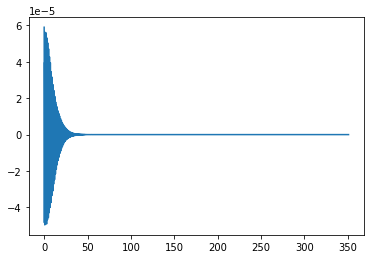

In [44]:
# y = (myds['eta_steric_bandpass'].isel(Nc=0)-myds['eta_steric_tidal'].isel(Nc=0))
# x = myds['eta_steric_bandpass'].isel(Nc=1)

y = myds['eta_steric_non_phase_locked'].isel(Nc=3)
tdays = (myds.time-myds.time[0]).values.astype(float)/1e9/86400
X = tdays#[:,None]
dt = X[1]-X[0]

eta1 = 0.007
eta2 = 0.008
eta3 = 0.003
eta4 = 0.006

eta1 = np.log(0.007)
eta2 = np.log(0.003)
# eta3 = np.log(0.003)
# eta4 = np.log(0.006)

dt1 = np.log(10.)
dt2 = np.log(10.)
# dt3 = 10.
# dt4 = 10.

constant = np.log(1e-6)
gam1 = 2.
gam2 = 2.

nu1 = 2.
nu2 = 2.
# covfunc = nsit.oscillate_M2S2K1O1
# covfunc=oscillate_M2S2K1O1_logeta
# covfunc=oscillate_D2D1_logeta_constant
# covfunc=oscillate_D2D1_gmatern
# covfunc=oscillate_D2D1_legit2
covfunc=oscillate_D2D1_gmatern2

fmin, fmax = 0.7, 2.3
# fmin, fmax = 0.5, 2.4

#####

# covparams = (eta1, dt1, eta2, dt2, eta3, dt3, eta4, dt4)
# covparams = (eta1, dt1, eta2, dt2, nu, constant)
# covparams = (eta1, dt1, eta2, dt2, gam1, gam2, constant)
covparams = (eta1, dt1, eta2, dt2, nu1, nu2, constant)

# covparams = (eta1, dt1, eta2, dt2, constant)


acf = covfunc(X, X[0], covparams)

plt.figure()
plt.plot(X-X[0], acf)

acf.shape

In [45]:
%%time
# soln = nsit.estimate_spectral_params_whittle(y, X, covfunc, covparams, fmin, fmax)
inputs = dict(X=X, covfunc=covfunc, covparams_ic=covparams, fmin=fmin, fmax=fmax, method='nelder-mead')
soln = nsit.estimate_spectral_params_whittle_ufunc(y, **inputs)
np.exp(soln), invlogit(soln[4],scale=3.5), invlogit(soln[5],scale=3.5)

CPU times: user 13.9 s, sys: 72.4 ms, total: 14 s
Wall time: 14.4 s


(array([1.46270850e-02, 4.10600733e+00, 2.75750576e-03, 2.17891244e+00,
        3.59950021e+03, 1.49641784e-01, 2.76011899e-05]),
 3.499027912847382,
 0.45557342457972716)

Text(0.5, 0, 'f [cpd]')

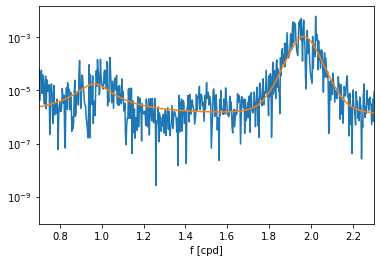

In [46]:

acf_best = covfunc(X, X[0], soln)
f, I = speccy.periodogram(y, dt)
f_S, S = speccy.bochner(acf_best, delta=dt)
plt.figure()
plt.semilogy(f, 2*I)
plt.semilogy(f_S,S)
plt.xlim(fmin, fmax)
plt.xlabel('f [cpd]')

In [99]:
# Make a dask function to do this everywhere


def myminfunc(params, X, y, f, I, covfunc,  dt, fmin, fmax):
    return -dwhittle_fast(X, y, f, I, covfunc, params, delta=dt, fmin=fmin, fmax=fmax)

def estimate_spectral_params_whittle(y, X, covfunc, covparams_ic, fmin, fmax,
            method='nelder-mead',
            options={'maxiter':5000},
            callback=None,
            bounds=None):
    
    #print(y.shape, X.shape)
    
    # Compute the periodogram outside of 
    dt = X[1]-X[0]
    f, I = speccy.periodogram(y, delta=dt)
    #print(f.shape, I.shape)
    
    soln=minimize(myminfunc, 
                  covparams_ic,
                  args=(X, y, f, I, covfunc, dt, fmin, fmax),
                  method=method,
                  bounds=bounds,
                  options=options,
                  callback=callback,
                 ) 
    #rint('done')

    return soln['x']



In [ ]:
#y = myds['eta_steric_bandpass']-myds['eta_steric_tidal']
y = (ds['eta_steric_bandpass']-ds['eta_steric_tidal']).isel(Nc=slice(10000,10010)).sel(time=slice(t1,t2))
#y = (ds['eta_steric_bandpass']-ds['eta_steric_tidal']).sel(time=slice(t1,t2))

tdays = (myds.time-myds.time[0]).values.astype(float)/1e9/86400

eta1 = 0.007
eta2 = 0.008
eta3 = 0.003
eta4 = 0.006

dt1 = 10.
dt2 = 10.
dt3 = 10.
dt4 = 10.
covfunc=oscillate_M2S2K1O1

fmin = 0.7
fmax = 2.2
#####

covparams = (eta1, dt1, eta2, dt2, eta3, dt3, eta4, dt4)

#y=y.expand_dims({'params':6})
y

In [ ]:
%%time
estimate_spectral_params_whittle(y.isel(Nc=0), X, covfunc, covparams, fmin, fmax)

In [ ]:
from dask import array as da
# Save and re-load the data
tmpfile = '../DATA/tmp.zarr'
xr.Dataset({'y':y}).to_zarr(tmpfile, compute=True, mode='w', encoding={'y':{'chunks':{'Nc':1}}})

y_ = xr.load_dataset('../DATA/tmp.zarr', engine='zarr', chunks={})['y']#.chunk({'Nc':1})
y_
#y_.data = da.from_array(y_.data) # Ensure we are dealing with a dask array

In [ ]:
# https://docs.xarray.dev/en/stable/examples/apply_ufunc_vectorize_1d.html
def estimate_spectral_params_whittle_ufunc(y, X=None, covfunc=None, covparams_ic=None, fmin=None, fmax=None):
    return estimate_spectral_params_whittle(y, X, covfunc, covparams_ic, fmin, fmax)

inputs = dict(X=X, covfunc=covfunc, covparams_ic=covparams, fmin=fmin, fmax=fmax)

params = xr.apply_ufunc(estimate_spectral_params_whittle_ufunc,
                          y_, 
                          dask='parallelized',
                          kwargs=inputs,
                          output_dtypes=[y_.dtype],
                          input_core_dims=(['time',],),
                          output_core_dims=(['params'],),
                          output_sizes={'params':len(covparams)},
                          vectorize=True,
                         )
params

In [ ]:
from dask.diagnostics import ProgressBar

with ProgressBar():
    params=params.compute()

In [ ]:
params.data.visualize('../FIGURES/dask_graph.svg')

In [ ]:
params.values

# Old stuff...

In [ ]:
f = S3Map("uwaoceanprocesses-suntans/NWS_2km_GLORYS_2013_2014_ssh_steric.zarr/", s3=s3)
varname = 'eta_steric'
units = 'cm'
scale = 100

f2 = S3Map("uwaoceanprocesses-suntans/NWS_2km_GLORYS_2013_2014_surface.zarr/", s3=s3)
# varname = 'uc'
# units = 'cm s$^{-1}$'
# scale = 100
varname = 'eta'
units = 'cm'
scale = 100

# varname = 'temp'
# units = 'degC'
# scale = 1.

ds = xr.open_dataset(f, engine='zarr')
ds2 = xr.open_dataset(f2, engine='zarr')

# These need filling in??
ds.suntans.xv=ds.xv.values
ds.suntans.yv=ds.yv.values

ds2

In [ ]:
def extract_point(xpt, ypt):
    dist = np.abs( (ds.xv.values-xpt) + 1j*(ds.yv.values-ypt))
    idx = np.argwhere(dist==dist.min())[0,0]

    return xr.merge([ds.isel(Nc=idx), ds2.isel(Nc=idx)], compat='override').drop_vars(['xp','yp','cells'])


In [ ]:
t1,t2 = '2013-07-15','2014-07-01'
# t1,t2 = '2014-01-02','2014-01-30'
myds = xr.concat([
                  extract_point( 115, -10.),
                    extract_point( 123.1391, -13.9329),
                  extract_point( 122.8290, -13.9881),
                  extract_point( 123.0319, -14.2290),

                 ], dim='Nc').sel(time=slice(t1,t2))
myds

In [ ]:
# Need to fix the time because the restart at each month lead to non-continuous time stepping
# Find and remove duplicate time entries
tsec = (myds.time.values-myds.time.values[0]).astype(float)/1e9
dt = np.ones(tsec.shape)

dt[1:] = tsec[1:]-tsec[0:-1]
dt[0] = dt[1]*1

#plt.plot(dt)

#badidx = dt<dt.max()
#dt[np.argwhere(badidx)]

remove_idx = dt==60.
# fix_idx = dt==3540.

# myds.time.isel(time=fix_idx) + np.timedelta64(60,'s')
myds2 = myds.isel(time=~remove_idx)

# # Check that the time is now continuous
# time = myds2.time.values
# tdays = (time-time[0]).astype(float)/1e9

# plt.plot(np.diff(tdays))
# myds2.time.shape, myds.time.shape


In [ ]:
plt.figure()
myds2['eta_steric'].isel(Nc=0).plot(lw=0.2)

In [ ]:
# Calculate the Coriolis frequency

Nc = 1

ypt =lat= myds2['yv'].isel(Nc=Nc).values
xpt = myds2['xv'].isel(Nc=Nc).values

f_coriolis = 4*np.pi/86400 * np.sin(lat*np.pi/180)
f_cpd = np.abs(f_coriolis*86400/(2*np.pi))
f_cpd, f_coriolis



In [ ]:
from scipy import signal

In [ ]:
# Compute the power spectrum of the signal
u=myds2['eta_steric'].isel(Nc=Nc)
time = u.time.values
nperseg = 2**12


# dt = (time[1]-time[0]).astype('float')/1e9
dt = 3600.
dt_days = dt/86400

y = u.values * scale
f, Puu= signal.welch(y-y.mean(), fs=1/dt_days, nperseg=nperseg)

print(nperseg, y.shape)
print('Length of each segment [days]: ', nperseg*dt/86400)

# Check the scaling by comparing the signal variance to the integral under the power spectrum
df = f[1] - f[0]
print(nperseg, y.shape, df, np.mean(np.diff(f)))
print(np.var(y-y.mean()), np.trapz(Puu, dx=df), np.var(y)/np.trapz(Puu, dx=df))


plt.figure()
ax=plt.subplot(111)
plt.loglog(f, Puu, lw=0.5)

plt.xlabel('ω [cycles per day]')
plt.ylabel('PSD [('+units+')$^2$cpd$^{-1}$]')
plt.grid(b=True,ls=':')
ax.set_ylim(1e-5, 1e5)
ax.axvline(f_cpd, c='k', ls=':')
ax.text(f_cpd+0.1, 1e-1, '$f$')
plt.title('Longitude: {:3.2f}$^\circ$, Latitude: {:3.2f}$^\circ$'.format(xpt,ypt))
plt.tight_layout()

# \n Water Depth: {:3.1f} m total_depth

In [ ]:
# Use the sfoda timeseries class to do the filtering
from sfoda.utils.timeseries import timeseries


In [ ]:
time = myds2['time'].values
T = timeseries(time, myds2['eta_steric'].isel(Nc=Nc).values,)

In [ ]:

T_tidal = timeseries(myds2['time'].values, T.filt([34*3600, 6*3600], btype='band'))
T_low = timeseries(myds2['time'].values, T.filt([34*3600], btype='low'))

T.plot()
T_tidal.plot(c='r')
T_low.plot(c='m')

In [ ]:
amp, phs, frq, mean, yfit, yrms  = T_tidal.tidefit(frqnames=['M2','S2','N2','K1','O1','P1','Q1'])
T_stat = timeseries(time, yfit)
T_nonstat = timeseries(time, T_tidal.y - yfit)

T_tidal.plot(c='r')
T_nonstat.plot()

In [ ]:
# T_tidal.psd()
T_nonstat.psd(c='r',lw=0.5)
plt.ylim(1e-4,1e3)
plt.xlim(4e-5, 3e-4)

# Estimate the spectral parameters with a GP

In [ ]:
from gptide import cov
from gptide import GPtideScipy, GPtideToeplitz
import numpy as np
import matplotlib.pyplot as plt

import corner
import arviz as az

from scipy import stats
from gptide import stats as gpstats

In [ ]:
def oscillate_1d(x, xpr, params, itfunc=cov.matern32):
    """
    1D Oscillatory kernel
    """
    eta, d, l = params
    
    return eta**2 * itfunc(x, xpr, d) * cov.cosine(x, xpr, l)

def oscillate_M2S1(x, xpr, params, lt = [12.42/24, 1.], itfunc=cov.matern32):

    eta1, d1, eta2, d2 = params
    
    C = oscillate_1d(x, xpr, (eta1, d1, lt[0]), itfunc=itfunc)
    C += oscillate_1d(x, xpr, (eta2, d2, lt[1]), itfunc=itfunc)
    return C

def oscillate_M2S2S1(x, xpr, params, lt = [12.42/24, 12/24, 1.], itfunc=cov.matern32):

    eta1, d1, eta2, d2,eta3, d3= params
    
    C = oscillate_1d(x, xpr, (eta1, d1, lt[0]), itfunc=itfunc)
    C += oscillate_1d(x, xpr, (eta2, d2, lt[1]), itfunc=itfunc)
    C += oscillate_1d(x, xpr, (eta3, d3, lt[2]), itfunc=itfunc)

    return C

In [ ]:
%%time


tdays = (time-time[0]).astype(float)/1e9/86400
X = tdays[:,None]


covfunc = oscillate_M2S2S1
eta1 = 0.007
eta2 = 0.006
eta3 = 0.005
dt1 = 20.
dt2 = 20
dt3 = 10

noise = 0.001

cov_kwargs = {'itfunc':cov.matern32}
#####

covparams = (eta1, dt1, eta2, dt2, eta3, dt3)

GP_s = GPtideScipy(X, X.copy(), noise, covfunc, covparams, cov_kwargs=cov_kwargs)

# Use the .prior() method to obtain some samples
zd = GP_s.prior(samples=1)

plt.plot(X, zd)
plt.plot(X, T_nonstat.y,'r', lw=0.4)

In [ ]:
T_nonstat_guess = timeseries(time, zd.ravel())

T_nonstat_guess.psd()
T_nonstat.psd(c='r',lw=0.5)
plt.ylim(1e-4,1e3)
plt.xlim(4e-5, 3e-4)

In [ ]:
%%time
GP_s.log_marg_likelihood(zd)

In [ ]:
%%time
GP = GPtideToeplitz(X, X.copy(), noise, covfunc, covparams, cov_kwargs=cov_kwargs)


In [ ]:
%%time
GP.log_marg_likelihood(zd)

In [ ]:
from gptide import mle

In [ ]:
mle?

In [ ]:
%%time
# Initial guess of the noise and covariance parameters (these can matter)
noise_ic = 0.001
covparams_ic = [eta1, dt1, eta2, dt2, eta3, dt3]

# There is no mean function in this case
# meanfunc = None
# meanparams_ic = ()
eps=1e-7
bounds = [(eps,1), (eps,1), (eps,1000), (eps,1), (eps,1000), (eps,1), (eps,1000)]
soln = mle(
    X, 
    T_nonstat.y.data[:,None], 
    covfunc, 
    covparams_ic,
    noise_ic,
    GPclass=GPtideToeplitz,
    bounds=bounds,
    method='nelder-mead',
    verbose=False)

soln['x']

In [ ]:
%%time
noise_best=soln['x'][0]
covparams_best=soln['x'][1:]


GP_s = GPtideScipy(X, X.copy(), noise_best, covfunc, covparams_best, cov_kwargs=cov_kwargs)

# Use the .prior() method to obtain some samples
zd = GP_s.prior(samples=1)

plt.figure()
plt.plot(X, zd,'r')
plt.plot(X, T_nonstat.y,'b', lw=0.5)

T_nonstat_best = timeseries(time, zd.ravel())

plt.figure()
T_nonstat_best.psd(c='r')
T_nonstat.psd(c='b',lw=0.5)
plt.ylim(1e-4,1e3)
plt.xlim(4e-5, 3e-4)

In [ ]:
T_nonstat_best.psd(c='r')
T_nonstat.psd(c='b',lw=0.5)
plt.ylim(1e-4,1e3)
plt.xlim(1e-4, 2e-4)

# MCMC

In [ ]:
from gptide import mcmc

In [ ]:
%%time

# Initial guess of the noise and covariance parameters (these can matter)
noise_prior      = gpstats.truncnorm(0.0, 0.1, 1e-15, 1)                 # noise -
covparams_priors = [gpstats.truncnorm(0.0, 0.1, 1e-15, 1),   
                    gpstats.truncnorm(20.0, 5, 1e-15, 100),   
                    gpstats.truncnorm(0.0, 0.1, 1e-15, 1),   
                    gpstats.truncnorm(20.0, 5, 1e-15, 100),   
                    gpstats.truncnorm(0.0, 0.1, 1e-15, 1),   
                    gpstats.truncnorm(20.0, 5, 1e-15, 100),   
                   ]


samples, log_prob, priors_out, sampler = mcmc.mcmc( X, 
                                                    T_nonstat.y.data[:,None],  
                                                    covfunc, 
                                                    covparams_priors,
                                                    noise_prior,
                                                    GPclass=GPtideToeplitz,
                                                    nwarmup=200,
                                                    niter=20,
                                                    nwalkers=100,
                                                    verbose=False)

samples.mean(axis=0)


In [ ]:

%%time
noise_best=samples.mean(axis=0)[0]
covparams_best=samples.mean(axis=0)[1:]


GP_s = GPtideScipy(X, X.copy(), noise_best, covfunc, covparams_best, cov_kwargs=cov_kwargs)

# Use the .prior() method to obtain some samples
zd = GP_s.prior(samples=1)

plt.figure()
plt.plot(X, zd,'r')
plt.plot(X, T_nonstat.y,'b', lw=0.5)

T_nonstat_best = timeseries(time, zd.ravel())

plt.figure()
T_nonstat_best.psd(c='r')
T_nonstat.psd(c='b',lw=0.5)
plt.ylim(1e-4,1e3)
plt.xlim(4e-5, 3e-4)

In [ ]:
# Whittle likelihood 

Needs:
    - Periodogram
    - analytical spectral model